# 非正規な標準化残差を持つGARCHでS&P500先物データのモデル化を試みる

前回の解析でARCHとGARCHモデルをそれぞれ当てはめてみたが、標準化残差が正規分布に従っていなかったため、当てはめは上手くいっていなかった。そこで、非正規な標準化残差を持つモデルを定義し、これでデータのばらつきを説明することを試みる。

In [1]:
%matplotlib inline

import arch
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
import statsmodels.tsa as tsa
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [2]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

prods = ['S&P500先物', '金先物']

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [3]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100


# 2019年の1年間のみのデータ

In [4]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

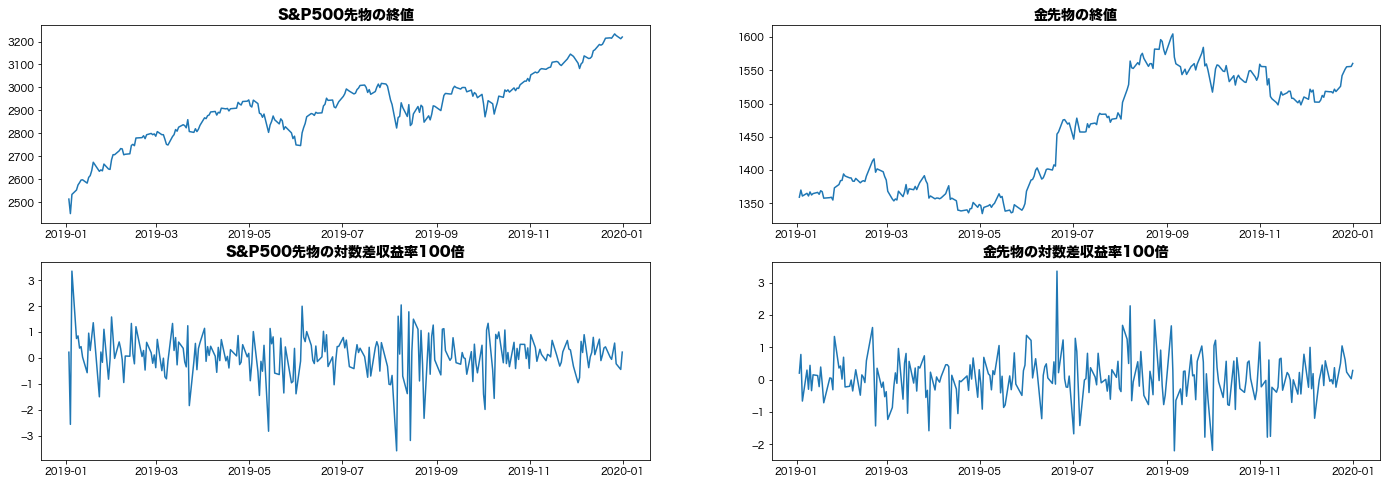

In [6]:
# 比較のため価格と対数差収益率を可視化しておく
fig, ax = plt.subplots(2, 2, figsize=(24,8))
for i, prod in enumerate(prods):
    ax[0,i].plot(rrdfs2019[i].index, rrdfs2019[i]['Close'])
    ax[0,i].set_title(f'{prod}の終値', fontsize=14, fontweight='semibold')
    ax[1,i].plot(rrdfs2019[i].index, rrdfs2019[i]['logCDiff'])
    ax[1,i].set_title(f'{prod}の対数差収益率100倍', fontsize=14, fontweight='semibold')

# 標準化残差の標準正規分布からのずれ

まず、ARCHモデルの当てはめ残差が標準正規分布の理論値からどの程度ずれているか視覚的に確認する

In [39]:
# 改めてARCHモデルを当てはめて標準化残差を得る

arch_models = [arch.arch_model(df['logCDiff'], vol='ARCH') for df in rrdfs2019]
aresults = [am.fit() for am in arch_models]

_ = [print(f'{prod}にARCHモデルを当てはめたときのAIC：{res.aic}') for res, prod in zip(aresults, prods)]

Iteration:      1,   Func. Count:      5,   Neg. LLF: 298.9495233625239
Iteration:      2,   Func. Count:     13,   Neg. LLF: 298.9307260688976
Iteration:      3,   Func. Count:     21,   Neg. LLF: 298.93068249306947
Iteration:      4,   Func. Count:     28,   Neg. LLF: 298.93066660614454
Iteration:      5,   Func. Count:     33,   Neg. LLF: 298.93065892211575
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 298.9306589221155
            Iterations: 5
            Function evaluations: 33
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 270.08537294070663
Iteration:      2,   Func. Count:     13,   Neg. LLF: 269.87670148533425
Iteration:      3,   Func. Count:     21,   Neg. LLF: 269.80231811152265
Iteration:      4,   Func. Count:     26,   Neg. LLF: 267.0306384400674
Iteration:      5,   Func. Count:     31,   Neg. LLF: 267.0232660954994
Iteration:      6,   Func. Count:     36,   Neg. LLF: 267.02314893

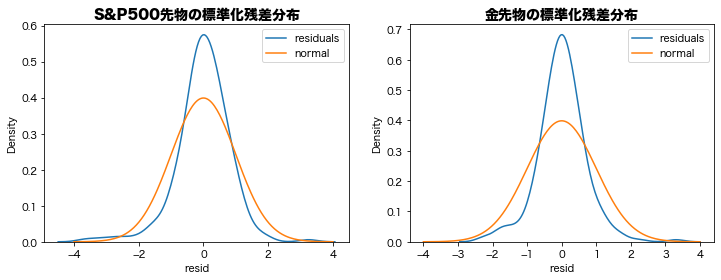

In [37]:
# 標準化残差の密度関数を推定
xx = np.linspace(-4, 4, 200)
yy = stats.norm.pdf(xx)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for  i, prod in enumerate(prods):
    sns.kdeplot(aresults[i].resid, label='residuals', ax=ax[i])
    ax[i].plot(xx, yy, label='normal')
    ax[i].set_title(f'{prod}の標準化残差分布', fontsize=14, fontweight='semibold')
    ax[i].legend()

## 標準化残差がt分布に従うモデルを当てはめてみる
現場ですぐ使える時系列データ分析」の本ではskew normal分布を仮定したモデルを試していたが、次のセクションにまとめたようにpythonのarchパッケージには標準で入っていない。しかしt分布とskew t分布があるので、それらを試してみる。

In [42]:
# t分布を仮定
"""
有意水準は5%とする。

S&P500先物では、mu, omega, nuについてはp < 0.05なので推定値の信頼性は高いが、
標準化誤差に正規分布を仮定した時と同様にalphaについてはp > 0.05となっている。
alphaはボラティリティを決定する式の過去の誤差の2乗項の係数なので、このモデルでは誤差項の説明がうまくできていない。

金先物については以前の分析結果でARモデルの残差をホワイトノイズと仮定できたのでそれで十分だからこのモデルフィットを
試す理由がそもそもないが、参考までに試した。
"""
arch_t_models = [arch.arch_model(df['logCDiff'], vol='ARCH', dist='t') for df in rrdfs2019]
atresults = [am.fit() for am in arch_t_models]

_ = [print(res.summary()) for res in atresults]
_ = [print(f'{prod}にARCHモデルを当てはめたときのAIC：{res.aic}') for res, prod in zip(atresults, prods)]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 285.930043498979
Iteration:      2,   Func. Count:     15,   Neg. LLF: 285.5028837433342
Iteration:      3,   Func. Count:     22,   Neg. LLF: 285.2579262728789
Iteration:      4,   Func. Count:     29,   Neg. LLF: 284.83417336056567
Iteration:      5,   Func. Count:     36,   Neg. LLF: 284.630484811108
Iteration:      6,   Func. Count:     42,   Neg. LLF: 284.55762678083374
Iteration:      7,   Func. Count:     49,   Neg. LLF: 284.4998156414832
Iteration:      8,   Func. Count:     55,   Neg. LLF: 284.4513545583671
Iteration:      9,   Func. Count:     61,   Neg. LLF: 284.4401900459003
Iteration:     10,   Func. Count:     67,   Neg. LLF: 284.43747377367004
Iteration:     11,   Func. Count:     73,   Neg. LLF: 284.437397708291
Iteration:     12,   Func. Count:     79,   Neg. LLF: 284.4373962222126
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 284.4373962222188
            Iterations: 12


## 標準化誤差がskew t分布に従うモデルを当てはめてみる

In [46]:
# skew t分布を仮定
"""
有意水準は5%とする。

S&P500先物では、t分布仮定の時よりalphaのp値が小さくなったがそれでもp > 0.05となっている。
また、skew t分布特有のパラメータであるlambdaの推定値についてもp > 0.05となっている。
このモデルでも誤差項の説明がうまくできていない。

金先物については参考までに試した。
"""
arch_st_models = [arch.arch_model(df['logCDiff'], vol='ARCH', dist='skewt') for df in rrdfs2019]
astresults = [am.fit() for am in arch_st_models]

_ = [print(res.summary()) for res in astresults]
_ = [print(f'{prod}にARCHモデルを当てはめたときのAIC：{res.aic}') for res, prod in zip(astresults, prods)]

Iteration:      1,   Func. Count:      7,   Neg. LLF: 285.9300438863752
Iteration:      2,   Func. Count:     17,   Neg. LLF: 285.46118555950903
Iteration:      3,   Func. Count:     25,   Neg. LLF: 283.6721260218171
Iteration:      4,   Func. Count:     34,   Neg. LLF: 283.36229203177413
Iteration:      5,   Func. Count:     43,   Neg. LLF: 283.3509657750944
Iteration:      6,   Func. Count:     51,   Neg. LLF: 283.0026186614125
Iteration:      7,   Func. Count:     59,   Neg. LLF: 282.9406593068603
Iteration:      8,   Func. Count:     66,   Neg. LLF: 282.91491530445694
Iteration:      9,   Func. Count:     73,   Neg. LLF: 282.9089877487949
Iteration:     10,   Func. Count:     80,   Neg. LLF: 282.908650710487
Iteration:     11,   Func. Count:     87,   Neg. LLF: 282.9086381420916
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 282.90863814209126
            Iterations: 11
            Function evaluations: 87
            Gradient evaluations

# 標準化残差が標準正規分布に従うように、モデルの構造を変えてみる
モデルの当てはまりを改善する方法として
- 標準化残差の分布としてskew normal分布などの非正規な分布を仮定することで残差分布の説明力を上げる
- モデルの構造自体を変えて当てはまりをよくすることで、標準化残差がより正規分布に近づくようにする

「現場ですぐ使える時系列データ分析」の本では前者をRで試して成功していたが、pythonの`arch`パッケージでは残差分布としてskew normal分布が標準では入っていない（[ここのdist引数](https://arch.readthedocs.io/en/latest/univariate/introduction.html#model-constructor)の説明に設定可能な分布が列挙されている）。

そこで今回は、本書内で発展として紹介されていた後者の方法を試す。

## S&P500先物データへのEGARCHモデル当てはめ

EGARCH: exponential GARCH



# まとめ

分析ではS&P500先物と金先物両方について結果を出したが、以前の分析結果から金先物についてはそもそもARモデルで十分ということがわかっておりARCHモデルを試す理由がないため、ここではS&P500先物の結果についてのみまとめる。

## 非正規な標準化誤差を仮定することでモデルの当てはめがうまくいったか
うまくいかなかった。書籍内で試されていたskew normal分布はpythonでは簡単には使えなかったため、t分布とskew t分布を試した。どちらを試してもパラメータ推定のp値はp > 0.5
